In [1]:
import csv
import datetime as dt
from datetime import date
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
file_location = 'C:\\Users\\Tan\\Desktop\\GA\\Capstone\\know_customer_daily_data.csv'

In [5]:
f = pd.read_csv(file_location)

In [6]:
df = pd.DataFrame(f)

In [7]:
df['DateTime'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [8]:
df.head(5)

,date,id,invoices_no,categories,quantity,unitprice,gross,top_products,DateTime
0,2010-12-01,12748.0,1,1,1,4.950000,4.95,1.000000,2010-12-01
1,2010-12-01,12838.0,1,59,228,1.973390,390.79,0.576271,2010-12-01
2,2010-12-01,12868.0,1,12,112,3.170833,203.30,0.833333,2010-12-01
3,2010-12-01,12921.0,1,15,140,2.483333,322.40,0.933333,2010-12-01
4,2010-12-01,12947.0,1,17,184,2.960588,304.04,0.470588,2010-12-01


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17305 entries, 0 to 17304
Data columns (total 9 columns):
date            17305 non-null object
id              17305 non-null float64
invoices_no     17305 non-null int64
categories      17305 non-null int64
quantity        17305 non-null int64
unitprice       17305 non-null float64
gross           17305 non-null float64
top_products    17305 non-null float64
DateTime        17305 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 1.2+ MB


In [10]:
# Apply RFM customer segmentation model on monthly periodicity, using a 90d rolling window.
# Recency would be number of days since last transaction
# Monetary would be total gross revenues over 90 days
# Frequency would be the number of transactions over 90 days
# Finally, aggregate the daily data to montly data...

# Create "days_since_last" variable

In [11]:
# "days_since_last" indicates how many days since last transaction
df['days_since_last'] = (df.groupby('id')['DateTime']
                 .apply(lambda x: (x - x.shift(1)).dt.days))

In [12]:
# Check if new variable is good, using one customer example
df[df['id']==18283]

,date,id,invoices_no,categories,quantity,unitprice,gross,top_products,DateTime,days_since_last
1426,2011-01-06,18283.0,1,57,61,1.771053,108.45,0.771930,2011-01-06,NaN
1941,2011-01-23,18283.0,1,45,67,1.850000,106.55,0.644444,2011-01-23,17.0
3222,2011-02-28,18283.0,1,30,59,2.351667,102.90,0.533333,2011-02-28,36.0
5450,2011-04-21,18283.0,1,56,87,1.478929,117.68,0.714286,2011-04-21,52.0
6732,2011-05-23,18283.0,1,44,62,1.710000,99.47,0.909091,2011-05-23,32.0
7685,2011-06-14,18283.0,1,24,52,2.042917,103.72,0.875000,2011-06-14,22.0
8115,2011-06-23,18283.0,1,87,157,1.526667,203.81,0.793103,2011-06-23,9.0
8908,2011-07-14,18283.0,2,57,102,1.627368,143.19,0.807018,2011-07-14,21.0
11051,2011-09-05,18283.0,1,47,95,1.401915,134.90,0.851064,2011-09-05,53.0
13992,2011-10-27,18283.0,1,40,63,2.087000,114.65,0.675000,2011-10-27,52.0


# Create the "frequency" & "monetary variables

In [13]:
df.set_index('DateTime', inplace=True, drop=True)

In [14]:
# Create dates for entire sample period, which needs to be in same format as the "date" in df
dates = [i.date() for i in pd.date_range(start='12/01/2010', end='12/09/2011')] 

In [15]:
temp_freq = (df.groupby('id')['invoices_no']
    .apply(lambda x: x.reindex(dates) 
                      .fillna(0) 
                      .shift() # Not including the current day
                      .rolling(90)
                      .sum()) 
    .reset_index()
    .rename(columns={'invoices_no': 'trans_90d', 
                     'DateTime': 'date'}))

temp_freq['date'] = pd.to_datetime(temp_freq['date'], format='%Y-%m-%d', utc=True)

In [16]:
temp_money = (df.groupby('id')['gross']
    .apply(lambda x: x.reindex(dates)  
                      .fillna(0)
                      .shift() 
                      .rolling(90)
                      .sum()) 
    .reset_index()
    .rename(columns={'gross': 'revenue_90d', 
                     'DateTime': 'date'}))

temp_money['date'] = pd.to_datetime(temp_money['date'], format='%Y-%m-%d', utc=True)

In [17]:
# Merging on datetime values can be tricky. Need to set utc=True beforehand.
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', utc=True)

In [18]:
df = df.merge(temp_freq, on=['id', 'date'])

In [19]:
df = df.merge(temp_money, on=['id', 'date'])

In [20]:
# Average gross revenues might be a good alternative Monetary variable, rather than total gross revenues...
# Generating an average gross revenue variable:
def avg_gross(row):
    if row['trans_90d'] == 0:
        return 0
    elif row['revenue_90d'] == 0:
        return 0
    else:
        return row['revenue_90d']/row['trans_90d']
    
df['avg_revenue_90d'] = df.apply(lambda row: avg_gross(row), axis=1)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17305 entries, 0 to 17304
Data columns (total 12 columns):
date               17305 non-null datetime64[ns, UTC]
id                 17305 non-null float64
invoices_no        17305 non-null int64
categories         17305 non-null int64
quantity           17305 non-null int64
unitprice          17305 non-null float64
gross              17305 non-null float64
top_products       17305 non-null float64
days_since_last    13358 non-null float64
trans_90d          14082 non-null float64
revenue_90d        14082 non-null float64
avg_revenue_90d    14082 non-null float64
dtypes: datetime64[ns, UTC](1), float64(8), int64(3)
memory usage: 1.7 MB


In [22]:
# Check if "frequency" & "monetary" variables are good on a random customer...
df[df.id==14527].head(30)

,date,id,invoices_no,categories,quantity,unitprice,gross,top_products,days_since_last,trans_90d,revenue_90d,avg_revenue_90d
27,2010-12-01 00:00:00+00:00,14527.0,1,1,-1,27.500000,-27.50,0.000000,NaN,NaN,NaN,NaN
263,2010-12-05 00:00:00+00:00,14527.0,2,29,59,6.180690,263.66,0.655172,4.0,NaN,NaN,NaN
602,2010-12-09 00:00:00+00:00,14527.0,1,29,48,4.891034,224.38,0.689655,4.0,NaN,NaN,NaN
952,2010-12-15 00:00:00+00:00,14527.0,2,30,50,6.169333,242.38,0.666667,6.0,NaN,NaN,NaN
1194,2010-12-20 00:00:00+00:00,14527.0,2,20,23,6.624000,124.97,0.800000,5.0,NaN,NaN,NaN
1337,2011-01-05 00:00:00+00:00,14527.0,2,25,32,7.820800,206.78,0.520000,16.0,NaN,NaN,NaN
1520,2011-01-10 00:00:00+00:00,14527.0,1,21,37,5.976190,167.60,0.714286,5.0,NaN,NaN,NaN
1820,2011-01-19 00:00:00+00:00,14527.0,1,19,45,6.050000,172.15,0.842105,9.0,NaN,NaN,NaN
2005,2011-01-25 00:00:00+00:00,14527.0,1,11,14,7.354545,90.90,0.909091,6.0,NaN,NaN,NaN
2222,2011-01-31 00:00:00+00:00,14527.0,1,14,22,6.232143,101.80,0.428571,6.0,NaN,NaN,NaN


In [23]:
# Now to drop all the null values

In [24]:
df = df[~df['days_since_last'].isnull()]

In [25]:
df = df[~df['revenue_90d'].isnull()]

In [26]:
# No null values in DF
df.isnull().values.any()

False

# Aggregating to monthly data

In [27]:
# These three steps create a DateTime index, then transforms the index to only month-end dates
df['dateindex'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [28]:
df.set_index('dateindex', inplace=True, drop=True)

In [29]:
df.index = df.index.to_period('M').to_timestamp('M')

C:\Users\Tan\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11706 entries, 2011-03-31 to 2011-12-31
Data columns (total 12 columns):
date               11706 non-null datetime64[ns, UTC]
id                 11706 non-null float64
invoices_no        11706 non-null int64
categories         11706 non-null int64
quantity           11706 non-null int64
unitprice          11706 non-null float64
gross              11706 non-null float64
top_products       11706 non-null float64
days_since_last    11706 non-null float64
trans_90d          11706 non-null float64
revenue_90d        11706 non-null float64
avg_revenue_90d    11706 non-null float64
dtypes: datetime64[ns, UTC](1), float64(8), int64(3)
memory usage: 1.2 MB


In [31]:
df['trans_date'] = df['date'].apply(lambda x:x.date())

In [32]:
df.head()

,date,id,invoices_no,categories,quantity,unitprice,gross,top_products,days_since_last,trans_90d,revenue_90d,avg_revenue_90d,trans_date
dateindex,,,,,,,,,,,,,
2011-03-31,2011-03-01 00:00:00+00:00,12747.0,1,12,146,3.106667,310.78,0.916667,40.0,3.0,1009.31,336.436667,2011-03-01
2011-03-31,2011-03-01 00:00:00+00:00,12971.0,1,3,136,1.620000,161.80,0.666667,5.0,19.0,1636.07,86.108947,2011-03-01
2011-03-31,2011-03-01 00:00:00+00:00,13110.0,1,27,68,5.269630,268.60,0.740741,19.0,2.0,235.75,117.875000,2011-03-01
2011-03-31,2011-03-01 00:00:00+00:00,13599.0,1,15,349,2.695333,580.57,0.733333,19.0,7.0,683.30,97.614286,2011-03-01
2011-03-31,2011-03-01 00:00:00+00:00,13880.0,1,9,94,2.616667,200.10,0.777778,13.0,2.0,308.00,154.000000,2011-03-01


In [33]:
df['cust_id'] = df['id']

In [34]:
id_grouping = df.groupby([df.index.year, df.index.month, 'cust_id']).agg({'id': 'last', 'invoices_no': 'sum', 
                                        'categories': 'mean', 'quantity': 'sum', 'unitprice': 'mean', 'gross': 'sum', 
                                        'top_products': 'mean', 'days_since_last': 'last',  'trans_90d': 'last', 
                                        'revenue_90d': 'last', 'avg_revenue_90d': 'last', 'trans_date': 'last'})

In [35]:
# The variables record the transactions of each individual customer per month
# sum "invoices_no" will give the total number of transactions per month
# mean "categories" will give the average number of product categories purchased per transaction per month
# sum "quantity" will give the total number of individual items purchased per month
# mean "unitprice" will give the average price of the individual items purchased per month
# sum "gross" will give the total gross spending per month
# mean "top_products" will give the proportion of top 20% products in the monthly purchases

In [36]:
id_grouping['dateindex'] = pd.to_datetime(id_grouping['trans_date'], format='%Y-%m-%d')
id_grouping.set_index('dateindex', inplace=True, drop=True)
id_grouping.index = id_grouping.index.to_period('M').to_timestamp('M')

In [37]:
id_grouping.head(5)

,id,invoices_no,categories,quantity,unitprice,gross,top_products,days_since_last,trans_90d,revenue_90d,avg_revenue_90d,trans_date
dateindex,,,,,,,,,,,,
2011-03-31,12747.0,1,12.000000,146,3.106667,310.78,0.916667,40.0,3.0,1009.31,336.436667,2011-03-01
2011-03-31,12748.0,13,35.166667,807,1.928548,1011.94,0.428384,1.0,18.0,1439.61,79.978333,2011-03-25
2011-03-31,12823.0,1,1.000000,60,7.650000,459.00,1.000000,35.0,2.0,535.50,267.750000,2011-03-30
2011-03-31,12839.0,1,1.000000,-2,1.650000,-3.30,0.000000,10.0,3.0,1089.01,363.003333,2011-03-07
2011-03-31,12841.0,2,14.500000,191,1.516875,269.90,0.401786,20.0,7.0,986.33,140.904286,2011-03-27


In [38]:
id_grouping.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8055 entries, 2011-03-31 to 2011-12-31
Data columns (total 12 columns):
id                 8055 non-null float64
invoices_no        8055 non-null int64
categories         8055 non-null float64
quantity           8055 non-null int64
unitprice          8055 non-null float64
gross              8055 non-null float64
top_products       8055 non-null float64
days_since_last    8055 non-null float64
trans_90d          8055 non-null float64
revenue_90d        8055 non-null float64
avg_revenue_90d    8055 non-null float64
trans_date         8055 non-null object
dtypes: float64(9), int64(2), object(1)
memory usage: 818.1+ KB


In [39]:
id_grouping.id.nunique()

2638

In [40]:
df.id.nunique()

2638

In [41]:
id_grouping.describe()

,id,invoices_no,categories,quantity,unitprice,gross,top_products,days_since_last,trans_90d,revenue_90d,avg_revenue_90d
count,8055.000000,8055.000000,8055.000000,8055.000000,8055.000000,8055.000000,8055.000000,8055.000000,8055.000000,8055.000000,8055.000000
mean,15504.623712,1.685040,20.997726,343.505028,4.577203,583.294929,0.677068,49.804593,2.905897,1158.723470,299.430843
std,1588.078860,1.508438,24.052673,763.548120,24.879742,1660.222234,0.246324,57.775746,4.166611,4068.858256,385.406778
min,12747.000000,1.000000,1.000000,-1350.000000,0.060000,-1000.370000,0.000000,1.000000,0.000000,-1241.430000,-1241.430000
25%,14135.000000,1.000000,7.000000,86.000000,2.025500,173.450000,0.522727,11.000000,1.000000,165.940000,109.025000
50%,15498.000000,1.000000,15.000000,188.000000,2.799600,323.740000,0.697508,29.000000,2.000000,470.730000,226.842500
75%,16873.000000,2.000000,26.000000,358.000000,3.950000,578.475000,0.875000,65.000000,4.000000,1015.975000,372.785000
max,18287.000000,48.000000,530.000000,25662.000000,951.390000,70246.500000,1.000000,366.000000,84.000000,123737.110000,7152.500000


In [42]:
df.describe()

,id,invoices_no,categories,quantity,unitprice,gross,top_products,days_since_last,trans_90d,revenue_90d,avg_revenue_90d,cust_id
count,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000,11706.000000
mean,15467.320178,1.159491,20.577055,236.368785,4.847908,401.370293,0.677865,42.643943,4.614215,1794.355276,326.865368,15467.320178
std,1620.324488,0.488853,27.504850,528.244587,33.150417,1125.771513,0.273778,53.687268,7.304577,5202.351173,451.680598,1620.324488
min,12747.000000,1.000000,1.000000,-3679.000000,0.010000,-7460.950000,0.000000,1.000000,0.000000,-1425.790000,-1241.430000,12747.000000
25%,14068.000000,1.000000,4.000000,48.000000,1.958022,113.790000,0.500000,8.000000,1.000000,243.770000,123.773125,14068.000000
50%,15401.000000,1.000000,14.000000,138.000000,2.745000,275.535000,0.705882,22.000000,2.000000,627.015000,238.304091,15401.000000
75%,16869.000000,1.000000,26.000000,272.000000,3.948332,434.975000,0.911111,54.000000,5.000000,1458.380000,387.837857,16869.000000
max,18287.000000,12.000000,543.000000,25930.000000,2500.000000,71601.440000,1.000000,366.000000,84.000000,123737.110000,9465.066667,18287.000000


The ratio of the monthly mean "gross" to the daily mean is 1.45. The ratio of the monthly mean "quantity" to the daily mean is also 1.45. These are also consistent with the ratio of the monthly mean "invoices_no" to the daily mean. 

In [43]:
df = pd.DataFrame(id_grouping)

# Deleting outliers from monthly data

In [44]:
# 67 observations with "gross" of more than 3 std above the mean, but none of such magnitude below the mean
df.gross[(df.gross > 583.29 + 3*1660.22)].count()

67

In [45]:
# 119 observations with "gross" of more than 3 std above the mean, but none of such magnitude below the mean
df.invoices_no[(df.invoices_no > 1.68 + 3*1.51)].count()

119

In [46]:
df.shape

(8055, 12)

In [47]:
# Deleting these outliers (163 observations in total), or 2% of the observations
df = df[(df.gross < 583.29 + 3*1660.22)]
df = df[(df.invoices_no < 1.68 + 3*1.51)]
df.shape

(7892, 12)

# Customer clustering

In [48]:
# For frequency and monetary, the higher the values the better the ranking, unlike recency
def customer_cluster(cluster, group, df, ascending=True):
    initial = (df.groupby(cluster)[group] # This step is to generate a sorted index based on the 'group' mean
                .mean()
                .reset_index()
                .sort_values(by=group, ascending=True)
                .reset_index(drop=True)) 
    initial['index'] = initial.index # Throwing out the old index as a scoring variable
    final = df.reset_index().merge(initial, on=cluster).set_index('dateindex') # Merging with the original DF
    final = (final.drop([cluster], axis=1)
                .rename(columns={"index":cluster})) # Dropping the cluster scores, and renaming the old index as the cluster
    return final

In [49]:
def alt_cluster(cluster, group, df, ascending=False):
    initial = (df.groupby(cluster)[group] # This step is to generate a sorted index based on the 'group' mean
                .mean()
                .reset_index()
                .sort_values(by=group, ascending=False)
                .reset_index(drop=True)) 
    initial['index'] = initial.index # Throwing out the old index as a scoring variable
    final = df.reset_index().merge(initial, on=cluster).set_index('dateindex') # Merging with the original DF
    final = (final.drop([cluster], axis=1)
                .rename(columns={"index":cluster})) # Dropping the cluster scores, and renaming the old index as the cluster
    return final

In [50]:
kmeans = KMeans(n_clusters=5) # Try for more granularity with 6 clusters

In [51]:
kmeans.fit(df[['trans_90d']])
df['frequency'] = kmeans.predict(df[['trans_90d']])

In [52]:
df = customer_cluster('frequency', 'trans_90d', df, True)

In [53]:
df.shape

(7892, 14)

In [54]:
# 46% of observations are in frequency score==0!
df.groupby('frequency')['trans_90d_x'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency,,,,,,,,
0,3654.0,0.626710,0.483744,0.0,0.0,1.0,1.0,1.0
1,2919.0,2.725591,0.782169,2.0,2.0,3.0,3.0,4.0
2,852.0,5.715962,0.781140,5.0,5.0,6.0,6.0,7.0
3,396.0,9.636364,1.547261,8.0,8.0,9.0,11.0,13.0
4,71.0,18.323944,6.283254,14.0,15.0,16.0,20.0,57.0


In [55]:
kmeans.fit(df[['revenue_90d']])
df['monetary'] = kmeans.predict(df[['revenue_90d']])

In [56]:
df = customer_cluster('monetary', 'revenue_90d', df, True)

In [57]:
# 80% of observations are in monetary score==0!
df.groupby('monetary')['revenue_90d_x'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary,,,,,,,,
0,6308.0,383.472302,330.126232,-1241.43,87.795,325.92,622.510,1156.18
1,1359.0,1936.671127,682.983940,1157.89,1388.460,1742.72,2277.300,4001.63
2,187.0,6095.325989,1800.672933,4034.05,4629.190,5493.88,7093.870,11103.20
3,35.0,16378.442000,5162.500836,11365.02,13162.895,15107.09,17329.815,38391.26
4,3.0,90043.283333,11131.324294,80014.34,84054.970,88095.60,95057.755,102019.91


In [58]:
# Doing the alternative monetary score, using the average gross instead of the sum
kmeans.fit(df[['avg_revenue_90d']])
df['monetary_avg'] = kmeans.predict(df[['avg_revenue_90d']])

In [59]:
df = customer_cluster('monetary_avg', 'avg_revenue_90d', df, True)

In [60]:
# Alternative monetary score is skewed, but much less than the initial one
df.groupby('monetary_avg')['avg_revenue_90d_x'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_avg,,,,,,,,
0,3069.0,60.886323,75.327583,-1241.430,0.000000,46.046667,130.400000,172.75
1,3378.0,285.214969,70.531620,172.910,222.552083,282.003125,338.995833,433.70
2,1141.0,583.002192,118.133768,434.015,481.380000,554.227500,664.510000,874.55
3,262.0,1172.573069,256.988235,879.300,968.346250,1079.185000,1307.509250,1932.24
4,42.0,2763.767055,751.706339,1974.132,2146.692500,2499.216429,3197.072500,4730.00


In [61]:
kmeans.fit(df[['days_since_last']])
df['recency'] = kmeans.predict(df[['days_since_last']])

In [62]:
df = alt_cluster('recency', 'days_since_last', df, ascending=False)

In [63]:
# More than half of the observations are in recency score==5.
df.groupby('recency')['days_since_last_x'].describe()

,count,mean,std,min,25%,50%,75%,max
recency,,,,,,,,
0,174.0,283.936782,39.833490,232.0,250.0,275.0,315.0,366.0
1,433.0,178.101617,24.499316,142.0,158.0,174.0,198.0,231.0
2,1042.0,104.051823,17.764853,78.0,89.0,102.0,118.0,141.0
3,2121.0,50.816124,12.714282,33.0,40.0,49.0,61.0,77.0
4,4122.0,13.902475,8.855616,1.0,6.0,13.0,21.0,32.0


The individual RFM scores are highly skewed, with Monetary being the worst. Let's try to spread out the distribution of the scores by taking the natural log values of the Recency variable (as it has no negative values), and the cube root of the Frequency and Monetary variables.

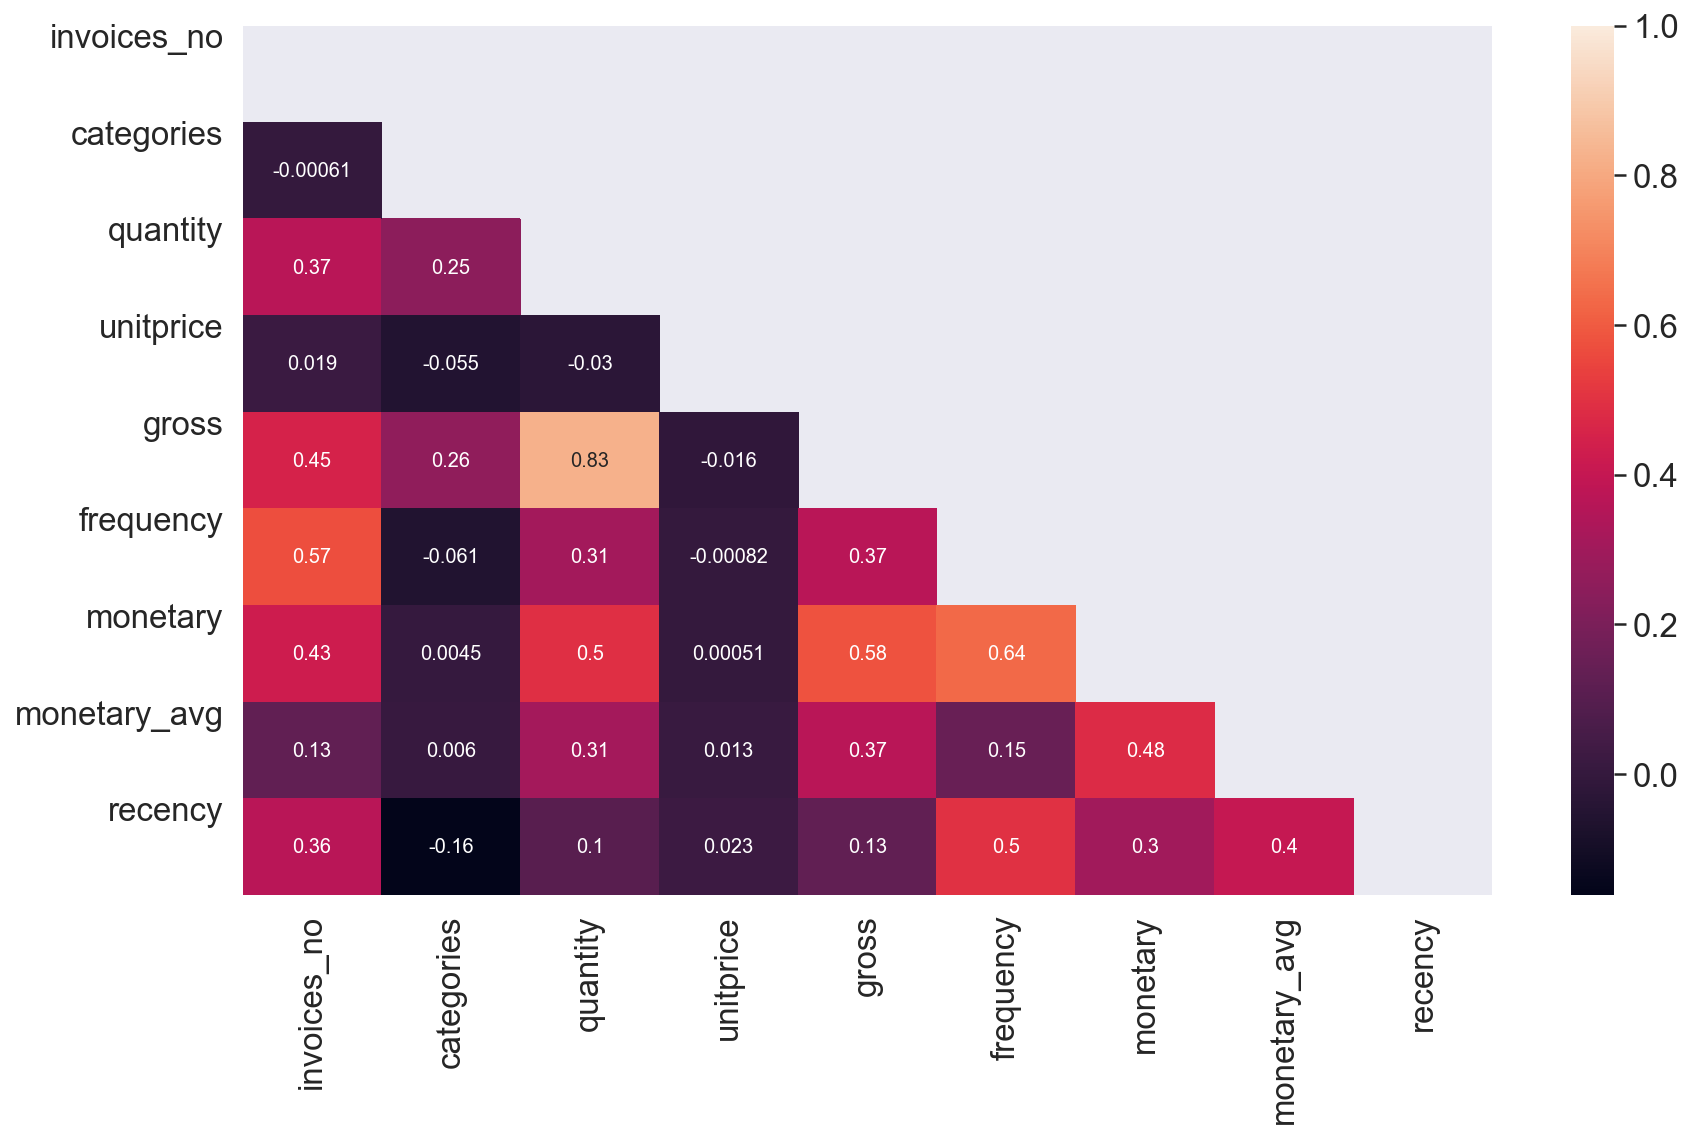

In [64]:
M = df[['invoices_no', 'categories', 'quantity', 'unitprice', 'gross', 'frequency', 'monetary', 'monetary_avg', 'recency']]

fig, ax = plt.subplots(figsize=(14, 8))

mask = np.zeros_like(M.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(M.corr(), mask=mask, annot=True, ax=ax)
ax.set_yticks(np.arange(0, df.shape[1])+0.1)
ax.set_ylim([M.shape[1], 0])
plt.show()

In [65]:
df.columns

Index(['id', 'invoices_no', 'categories', 'quantity', 'unitprice', 'gross',
       'top_products', 'days_since_last_x', 'trans_90d_x', 'revenue_90d_x',
       'avg_revenue_90d_x', 'trans_date', 'trans_90d_y', 'frequency',
       'revenue_90d_y', 'monetary', 'avg_revenue_90d_y', 'monetary_avg',
       'days_since_last_y', 'recency'],
      dtype='object')

In [66]:
df.drop(['trans_90d_y', 'frequency', 'revenue_90d_y', 'monetary', 'avg_revenue_90d_y', 'monetary_avg',
       'days_since_last_y', 'recency'], axis=1, inplace=True)

In [67]:
df.columns = ['id', 'invoices_no', 'categories', 'quantity', 'unitprice', 'gross', 'top_products', 'days_since_last', 
              'trans_90d', 'revenue_90d', 'avg_revenue_90d', 'trans_date']

### Clustering using transformed RFM indicators

In [68]:
df['ln_days_since_last'] = np.log(df.days_since_last)

In [69]:
df['cube_trans_90d'] = np.cbrt(df.trans_90d)

In [70]:
df['cube_revenue_90d'] = np.cbrt(df.revenue_90d)

In [71]:
df['cube_avg_revenue_90d'] = np.cbrt(df.avg_revenue_90d)

In [72]:
kmeans.fit(df[['cube_trans_90d']])
df['frequency'] = kmeans.predict(df[['cube_trans_90d']])

In [73]:
df = customer_cluster('frequency', 'cube_trans_90d', df, True)

In [74]:
# The Frequency score's distribution is a lot less skewed now
df.groupby('frequency')['cube_trans_90d_x'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency,,,,,,,,
0,1364.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2290.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2317.0,1.331845,0.089130,1.259921,1.259921,1.259921,1.442250,1.442250
3,1454.0,1.702828,0.114734,1.587401,1.587401,1.709976,1.817121,1.912931
4,467.0,2.196762,0.224454,2.000000,2.000000,2.154435,2.289428,3.848501


In [75]:
kmeans.fit(df[['cube_revenue_90d']])
df['monetary'] = kmeans.predict(df[['cube_revenue_90d']])

In [76]:
df = customer_cluster('monetary', 'cube_revenue_90d', df, True)

In [77]:
# So too for Monetary
df.groupby('monetary')['cube_revenue_90d_x'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary,,,,,,,,
0,1488.0,-0.133693,1.024753,-10.747499,0.000000,0.000000,0.000000,3.149803
1,2669.0,6.453296,0.984265,3.271066,5.770700,6.702872,7.221361,7.890166
2,2492.0,9.351108,0.895683,7.893109,8.585232,9.251234,10.039097,11.157460
3,1072.0,12.988237,1.425156,11.159280,11.844587,12.602936,13.840759,16.771024
4,171.0,20.572547,4.471375,16.786050,17.796825,19.210693,21.814398,46.726327


In [78]:
kmeans.fit(df[['cube_avg_revenue_90d']])
df['monetary_avg'] = kmeans.predict(df[['cube_avg_revenue_90d']])

In [79]:
df = customer_cluster('monetary_avg', 'cube_avg_revenue_90d', df, True)

In [80]:
df.groupby('monetary_avg')['cube_avg_revenue_90d_x'].describe()

,count,mean,std,min,25%,50%,75%,max
monetary_avg,,,,,,,,
0,1474.0,-0.148595,0.913349,-10.747499,0.000000,0.000000,0.000000,2.441299
1,2017.0,5.056562,0.622358,2.458209,4.767195,5.199316,5.513027,5.831086
2,2780.0,6.603201,0.441415,5.832236,6.217832,6.634719,6.954874,7.412069
3,1323.0,8.212566,0.589751,7.413404,7.706606,8.090992,8.643555,9.599309
4,298.0,10.996038,1.439316,9.617056,9.952785,10.549156,11.522346,16.786251


In [81]:
kmeans.fit(df[['ln_days_since_last']])
df['recency'] = kmeans.predict(df[['ln_days_since_last']])

In [82]:
df = alt_cluster('recency', 'ln_days_since_last', df, ascending=False)

In [83]:
df.groupby('recency')['ln_days_since_last_x'].describe()

,count,mean,std,min,25%,50%,75%,max
recency,,,,,,,,
0,1440.0,4.948472,0.362411,4.454347,4.651568,4.867534,5.187386,5.902633
1,2330.0,3.942678,0.278101,3.496508,3.713572,3.912023,4.174387,4.442651
2,2115.0,3.016628,0.277186,2.564949,2.772589,3.044522,3.295837,3.465736
3,1525.0,1.964741,0.334978,1.386294,1.791759,1.945910,2.197225,2.484907
4,482.0,0.590461,0.457092,0.000000,0.000000,0.693147,1.098612,1.098612


In [84]:
df.columns

Index(['id', 'invoices_no', 'categories', 'quantity', 'unitprice', 'gross',
       'top_products', 'days_since_last', 'trans_90d', 'revenue_90d',
       'avg_revenue_90d', 'trans_date', 'ln_days_since_last_x',
       'cube_trans_90d_x', 'cube_revenue_90d_x', 'cube_avg_revenue_90d_x',
       'cube_trans_90d_y', 'frequency', 'cube_revenue_90d_y', 'monetary',
       'cube_avg_revenue_90d_y', 'monetary_avg', 'ln_days_since_last_y',
       'recency'],
      dtype='object')

In [85]:
df.drop(['ln_days_since_last_x', 'cube_trans_90d_x', 'cube_revenue_90d_x', 'cube_avg_revenue_90d_x', 'cube_trans_90d_y', 
         'cube_revenue_90d_y', 'cube_avg_revenue_90d_y', 'ln_days_since_last_y',
         'top_products'], axis=1, inplace=True)

In [86]:
df.sort_index()

,id,invoices_no,categories,quantity,unitprice,gross,days_since_last,trans_90d,revenue_90d,avg_revenue_90d,trans_date,frequency,monetary,monetary_avg,recency
dateindex,,,,,,,,,,,,,,,
2011-03-31,12747.0,1,12.0,146,3.106667,310.78,40.0,3.0,1009.31,336.436667,2011-03-01,2,2,2,1
2011-03-31,16011.0,1,8.0,63,4.025000,118.55,35.0,2.0,347.09,173.545000,2011-03-29,2,1,1,1
2011-03-31,14194.0,5,24.0,628,3.923021,1023.04,2.0,5.0,1546.74,309.348000,2011-03-27,3,3,2,4
2011-03-31,15159.0,3,6.5,131,5.245833,636.25,3.0,4.0,1491.24,372.810000,2011-03-17,3,3,2,4
2011-03-31,16670.0,2,21.0,356,2.987875,582.48,8.0,5.0,1387.94,277.588000,2011-03-10,3,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31,14141.0,1,10.0,77,3.842000,226.35,57.0,4.0,367.52,91.880000,2011-12-07,3,1,1,1
2011-12-31,14621.0,1,16.0,254,1.702500,302.86,29.0,1.0,482.59,482.590000,2011-12-08,1,1,3,2
2011-12-31,16711.0,1,5.0,344,1.112000,295.60,23.0,1.0,445.56,445.560000,2011-12-06,1,1,3,2


### Creating a composite equal-weighted RFM score

In [87]:
# Using equal weights
df['rfm_equal'] = df['recency'] + df['frequency'] + df['monetary']

In [88]:
df.groupby('rfm_equal')['days_since_last', 'trans_90d', 'revenue_90d'].mean()

,days_since_last,trans_90d,revenue_90d
rfm_equal,,,
0,154.814516,0.000000,9.405966e-16
1,87.800000,1.000000,-6.490000e+01
2,74.504673,1.000000,8.209991e+01
3,58.163471,1.022200,2.544462e+02
4,42.089234,1.497575,3.881496e+02
5,29.225259,1.897267,5.646622e+02
6,20.217259,2.504569,7.578820e+02
7,15.806122,3.667800,1.030453e+03
8,11.948795,4.701807,1.552567e+03


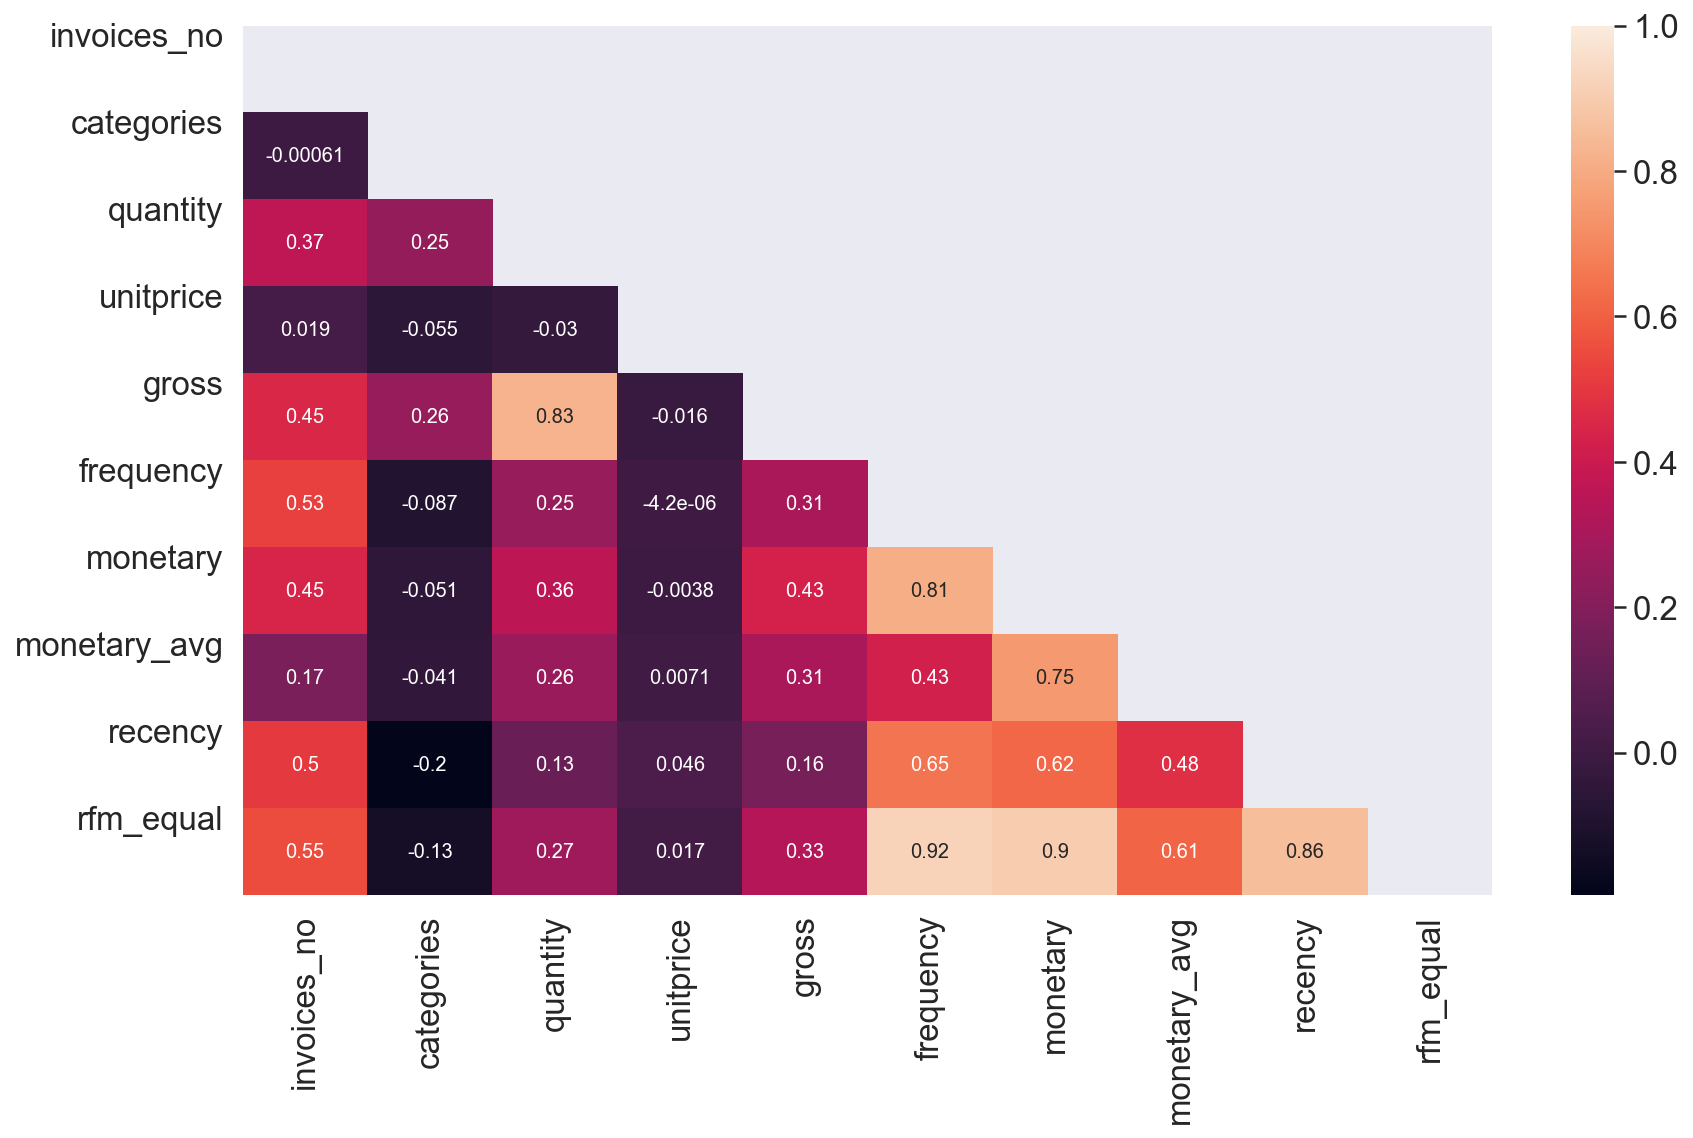

In [89]:
# The transformed RFM variables show similar strong positive correlations to the resultant "rfm_score" and "cust_class"
M = df[['invoices_no', 'categories', 'quantity', 'unitprice', 'gross', 'frequency', 'monetary', 'monetary_avg', 
        'recency', 'rfm_equal']]

fig, ax = plt.subplots(figsize=(14, 8))

mask = np.zeros_like(M.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(M.corr(), mask=mask, annot=True, ax=ax)
ax.set_yticks(np.arange(0, df.shape[1])+0.1)
ax.set_ylim([M.shape[1], 0])
plt.show()

What's interesting about the correlation chart above is that the individual Recency, Frequency and Monetary indicators have generally weak relationships with "gross", though all are positive. The individual RFM scores have stronger correlations (all positive again) with "invoices_no" or the number of monthly transactions. This is likely due to the existence of infrequent but large buyers in the dataset. 

This leads to the issue of the RFM framework being unintentionally weighted in favour of regular customers, if the three scores are simply added across with equal weighting into a composite indicator, as in the "rfm_score" variable. We can observe this in the correlation of +0.56 between the "rfm_equal" and "invoices_no", but only +0.34 between "rfm_equal" and "gross". So a naive equally-weighted composite RFM indicator is largely measuring the number of transactions by a customer per month. This is fine, but what if we wanted the composite indicator to track other customer metrics?

The "monetary_avg" score is also confirmed to be much less correlated to "frequency" than the initial "monetary" score. It would be better to use indicators that are not highly correlated to each other for crafting a composite indicator. As such, I would use the "monetary_avg" score from here as the Monetary indicator.

# Considerations for constructing the RFM composite indicator

There is no widely agreed methodology on how to weigh individual indicators for aggregation into a composite indicator. Weights typically have a major effect on the composite indicator value and on the resulting ranking, which is why weighting models need to be made explicit and transparent. 

Some commonly commonly used methods for weighting include the following:
- Equal weights
- Principal components analysis
- Regression analysis 
- Theoretical considerations
- Expert opinion

The point of crafting specialised indicators implies eschewing equal weights, and there is no theory to guide us here. And the three individual indicators are taken directly from the RFM framework and is already limited, so I don't think we need to undertake PCA. I will instead pursue the regression analysis approach.

For the example of how to go about building a bespoke composite RFM indicator, I would aim to build an indicator of monthly customer spending. That is after all the raison d'etre of businesses, though of course other aims are possible too. For this purpose, the monthly "gross" revenue will consequently be the dependent variable or target for the regression analysis.

In [90]:
#df.to_csv(r'C:\\Users\\Tan\\Desktop\\GA\\Capstone\\know_customer_monthly.csv', index=False)